In [ ]:
#!pip install wordcloud

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORTS

In [51]:
import csv
import os
import time
import datetime
import re

import numpy as np
import pandas as pd
import inflect
import pickle
from pickle import dump
from pickle import load
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from functools import partial

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.tokenize import sent_tokenize 
from nltk.tokenize import word_tokenize 

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2.4.1


In [52]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

def pretty_print(reviews, labels, idx):
    print("Sentiment {}: \t {}"  .format(labels[idx], reviews[idx][:100]))


def to_lower(text):
    """
    convert all characters to lower case
    """
    return text.lower()


# Import nltk stop codons
stop = set(stopwords.words('english'))

def clean_text(x):
    # split into tokens by white space
    tokens = str(x).split()
    # filter out stop words
    tokens = [tok for tok in tokens if not tok.lower() in stop]
    # filter out short words
    tokens = [tok for tok in tokens if len(tok)>1]
    # join the tokens
    return ' '.join(tokens)

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '', x)
    x = re.sub('[0-9]{4,}', '', x)
    x = re.sub('[0-9]{3,}', '', x)
    x = re.sub('[0-9]{2,}', '', x)
    return x

# save a dataset to file
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)
    
def load_dataset(filename):
    return load(open(filename, 'rb'))

def compute_ecdf(x, xlabel):
    n = len(x)
    x = np.sort(x)
    y = np.arange(1, n+1)/n
    plt.subplot()
    plt.plot(x, y, '.')
    plt.xlabel(xlabel)
    plt.ylabel("Empirical Cumulative Distribution")
    plt.show()
 
    
def compute_class_freqs(labels):
    """
    Compute positive and negative frequencies for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = np.sum(labels == 0, axis=0) / N
    return positive_frequencies, negative_frequencies

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -1 * K.mean((pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon) + 
                     neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon)))
        return loss

    return weighted_loss

def plot_performance(hist, model_name):
    """
    Plots the accuracy and loss during the training process.
    Args: 
    history: variable assigned to model.fit()
    model_name: A string identifying the model
    """
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    fig.suptitle("{} Training".format(model_name), fontsize=20)

    max_epoch = len(hist.history['accuracy'])+1
    epochs_list = list(range(1, max_epoch))

    ax1.plot(epochs_list, hist.history['accuracy'], color='b', linestyle='-', label='Training Data')
    ax1.plot(epochs_list, hist.history['val_accuracy'], color='r', linestyle='-', label ='Validation Data')
    ax1.set_title('Accuracy', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.legend(frameon=False, loc='lower center', ncol=2)

    ax2.plot(epochs_list, hist.history['loss'], color='b', linestyle='-', label='Training Data')
    ax2.plot(epochs_list, hist.history['val_loss'], color='r', linestyle='-', label ='Validation Data')
    ax2.set_title('Loss', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.legend(frameon=False, loc='upper center', ncol=2)
    
    if figure_directory:
        plt.savefig(figure_directory+"/history")
    plt.show()

# LOAD DATA

## Reviews

In [53]:
# Read the data into a pandas dataframe
# Filepath
file_path = os.path.join("/content/drive/MyDrive/sentiment_analysis/data/raw", "amazon_baby.csv")

# Read and sample few observations
all_products = pd.read_csv(file_path)
all_products.sample(5)

,name,review,rating
165724,9V Auto Adapter Car Vehicle Lighter adapter fo...,"Fast service, and worked for me car and pump! ...",5
22710,"Chicco Ct0.6 Capri Lightweight Stroller, Red","I am 5' 6"" and my husband is 6' 2"" and this st...",4
1916,The First Years Night and Day Bottle Warmer Sy...,"Easy to use, cooler works well to store 2 bott...",5
106007,Leachco Podster Sling-Style Infant Seat Lounge...,Our daughter was born two weeks ago and she LI...,5
78107,Trend Lab CribWrap Fleece Rail Cover for Long ...,This product is a must and I really wish I kne...,5


In [54]:
print(f"Number of Observations: {all_products.shape[0]}")
print(f"Number of Features: {all_products.shape[1]}")
print(f"Features: \n{all_products.columns.tolist()}")

Number of Observations: 183531
Number of Features: 3
Features: 
['name', 'review', 'rating']


In [55]:
print(f"Number of observations in raw dataset:{all_products.shape[0]}")

#  Drop reviews rated as 3
products = all_products.loc[all_products['rating']!=3, ['review', 'rating']]
print(f"Number of observations in the dataset after dropping neutral (3) reviews:{products.shape[0]}")

Number of observations in raw dataset:183531
Number of observations in the dataset after dropping neutral (3) reviews:166752


In [60]:
neutral_ratings = all_products.loc[all_products['rating']==3, ['review', 'rating']]
num_neutral_ratings = neutral_ratings.shape[0]
print(f"Number of reviews with neutral ratings: {num_neutral_ratings}")
assert all_products.shape[0]  == products.shape[0] + neutral_ratings.shape[0]

Number of reviews with neutral ratings: 16779


In [61]:
# Lowercase the token, remove NLTK english stopwords and include token that are longer than 1 character
products['review_clean'] = products['review'].apply(lambda x: clean_text(x))

In [62]:
products[['review','review_clean', 'rating']].head(5)

,review,review_clean,rating
1,it came early and was not disappointed. i love...,came early disappointed. love planet wise bags...,5
2,Very soft and comfortable and warmer than it l...,soft comfortable warmer looks...fit full size ...,5
3,This is a product well worth the purchase. I ...,product well worth purchase. found anything el...,5
4,All of my kids have cried non-stop when I trie...,"kids cried non-stop tried ween pacifier, found...",5
5,"When the Binky Fairy came to our house, we did...","Binky Fairy came house, special gift book help...",5


In [63]:
products.columns

Index(['review', 'rating', 'review_clean'], dtype='object')

## Target Feature - "Rating"

In [64]:
# Number of possible ratings
print(f"Number of unique review values: {all_products['rating'].nunique()}")

Number of unique review values: 5


5    107054
4     33205
3     16779
1     15183
2     11310
Name: rating, dtype: int64



Text(0, 0.5, 'number of reviews')

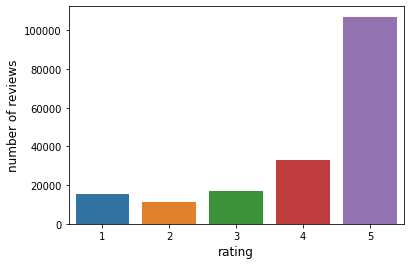

In [65]:
# Count number of reviews for each rating
print(all_products['rating'].value_counts())
print()
# Plot rating counts
sns.barplot(x=all_products['rating'].value_counts().index, y=all_products['rating'].value_counts())
plt.xlabel("rating", fontsize=12)
plt.ylabel("number of reviews", fontsize=12)

We will drop all neutral reviews i.e., reviews rated 3 and group reviews rated 1 and 2 as negative and reviews rated 4 and 5 as positive. 

In [66]:
# Ratings above 3 as positive and below 3 as negative.
products['sentiment'] = products['rating'].apply(lambda x: 1 if x >3 else 0)
products[['rating', 'sentiment']].sample(10)

,rating,sentiment
35070,5,1
77776,2,0
147925,5,1
10882,4,1
23375,5,1
167744,4,1
133328,4,1
173778,5,1
110885,5,1
167190,5,1


Text(0.5, 0, 'Sentiment')

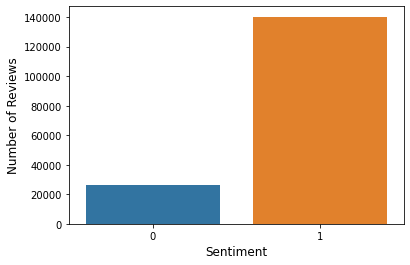

In [67]:
products['sentiment'].value_counts()
sns.barplot(x=products['sentiment'].value_counts().index, y=products['sentiment'].value_counts())
plt.ylabel("Number of Reviews", fontsize=12)
plt.xlabel("Sentiment", fontsize=12)

In [68]:
new_labels = tf.keras.utils.to_categorical(products['sentiment'], num_classes=2, dtype='float32')
print("labels:")
print(new_labels)

labels:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [69]:
reviews, labels = products['review_clean'].values, products['sentiment'].values

In [70]:
reviews

array(['came early disappointed. love planet wise bags wipe holder. keps osocozy wipes moist leak. highly recommend it.',
       'soft comfortable warmer looks...fit full size bed perfectly...would recommend anyone looking type quilt',
       'product well worth purchase. found anything else like this, positive, ingenious approach losing binky. love product much ownership daughter getting rid binky. proud herself, loves little fairy. love artwork, chart back, clever approach tool.',
       ...,
       'item looks great cool kids....I know Company great quality...',
       'extremely happy product. searching product like long time found right one. mum organic products unllike many others looked at, Tutti Bimbi Freezer Tray also BPA phthalates free. bright packaging ability choose colour attracted listing fact prepare meals generous portion size baby one time massive advantage working mum. freeze tray easily comes easy clip lid also protects freezer burn. found also put baby food tray di

In [71]:
num_pos_review = int(np.sum(new_labels, axis=0)[1])
num_neg_review = int(np.sum(new_labels, axis=0)[0])
total_num_reviews = len(reviews)

percent_pos_reviews = round(100* (num_pos_review/total_num_reviews),2)
percent_neg_reviews = round(100* (num_neg_review/total_num_reviews),2)

print(f"Total number of reviews in the dataset   : {len(reviews)}")
print(f"{num_pos_review} / {percent_pos_reviews}% Number of reviews with positive sentiment: {int(np.sum(new_labels, axis=0)[1])}")
print(f"{num_neg_review} / {percent_neg_reviews}% Number of reviews with negative sentiment: {int(np.sum(new_labels, axis=0)[0])}")

Total number of reviews in the dataset   : 166752
140259 / 84.11% Number of reviews with positive sentiment: 140259
26493 / 15.89% Number of reviews with negative sentiment: 26493


In [72]:
if os.path.exists("/content/drive/MyDrive/sentiment_analysis/data/processed/reviews_clean.pkl"):
    print("File Exists")
else:
    save_dataset(reviews, "/content/drive/MyDrive/sentiment_analysis/data/processed/reviews_clean.pkl")

File Exists


In [73]:
with open("/content/drive/MyDrive/sentiment_analysis/data/processed/reviews_clean.pkl", 'rb') as f:
    reviews = pickle.load(f)

reviews[:1]

array(['came early disappointed. love planet wise bags wipe holder. keps osocozy wipes moist leak. highly recommend it.'],
      dtype=object)

In [74]:
print("labels.txt : \t \t \t \t \t reviews.txt\n")
pretty_print(reviews, labels, 1)
pretty_print(reviews, labels, 11)
pretty_print(reviews, labels, 111)

labels.txt : 	 	 	 	 	 reviews.txt

Sentiment 1: 	 soft comfortable warmer looks...fit full size bed perfectly...would recommend anyone looking type qu
Sentiment 1: 	 originally gave nanny pad paper write information little one. would take park leave pad behind getti
Sentiment 0: 	 put yet disappointed color flowers. look purple pink.


# Generate WordCloud

In [75]:
positive_reviews = " ".join(review for review in products[products['sentiment'] == 1]['review_clean'])
negative_reviews = " ".join(review for review in products[products['sentiment'] == 0]['review_clean'])

In [76]:
positive_wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000).generate(positive_reviews)
negative_wordcloud = WordCloud(background_color='white', mode="RGBA", max_words=1000).generate(negative_reviews)

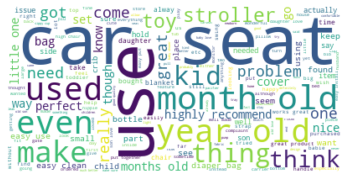

In [77]:
# Display the generated image:
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [78]:
# Save the image in the img folder:
positive_wordcloud.to_file("/content/drive/MyDrive/sentiment_analysis/figures/positive_reviews.png")

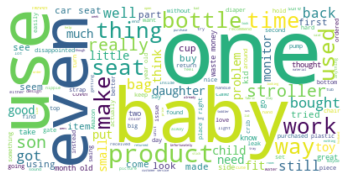

In [79]:
# Display the generated image:
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [80]:
# Save the image in the img folder:
negative_wordcloud.to_file("/content/drive/MyDrive/sentiment_analysis/figures/negative_reviews.png")

In [81]:
pos_freq, neg_freq = compute_class_freqs(new_labels)
pos_freq, neg_freq

(array([0.15887666, 0.84112334]), array([0.84112334, 0.15887666]))

In [82]:
pos_weights = neg_freq
neg_weights = pos_freq

pos_contribution = pos_freq * pos_weights 
neg_contribution = neg_freq * neg_weights

In [83]:
pos_weights, neg_weights

(array([0.84112334, 0.15887666]), array([0.15887666, 0.84112334]))

# DATA CLEANING

## convert the reviews to lowercase

# Split data for training

In [84]:
# Train Data
train_fraction = 0.8
train_sample = round(len(reviews) * train_fraction)

train_reviews = reviews[:train_sample]
train_labels = new_labels[:train_sample]

# Validation and Test data
test_valid_reviews = reviews[train_sample:]
test_valid_labels = new_labels[train_sample:]

valid_fraction = 0.5
valid_sample = round(len(test_valid_reviews) * valid_fraction)

valid_reviews = test_valid_reviews[: valid_sample]
valid_labels = test_valid_labels[: valid_sample]

test_reviews = test_valid_reviews[valid_sample:]
test_labels = test_valid_labels[valid_sample:]

In [85]:
if os.path.exists(os.path.join("/content/drive/MyDrive/sentiment_analysis/data/processed", "train.pkl")):
    print("File exists")
else:
    save_dataset([train_reviews, train_labels], "/content/drive/MyDrive/sentiment_analysis/data/processed/train.pkl")
    
if os.path.exists(os.path.join("/content/drive/MyDrive/sentiment_analysis/data/processed", "valid.pkl")):
    print("File exists")
else:
    save_dataset([valid_reviews, valid_labels], "/content/drive/MyDrive/sentiment_analysis/data/processed/valid.pkl")
    
if os.path.exists(os.path.join("/content/drive/MyDrive/sentiment_analysis/data/processed", "test.pkl")):
    print("File exists")
else:
    save_dataset([test_reviews, test_labels], "/content/drive/MyDrive/sentiment_analysis/data/processed/test.pkl")

File exists
File exists
File exists


In [86]:
train_reviews, train_labels = load_dataset("/content/drive/MyDrive/sentiment_analysis/data/processed/train.pkl")
valid_reviews, valid_labels = load_dataset("/content/drive/MyDrive/sentiment_analysis/data/processed/valid.pkl")
test_reviews, test_labels = load_dataset("/content/drive/MyDrive/sentiment_analysis/data/processed/test.pkl")

In [87]:
print("Sentiment : \t \t \t \t \t training reviews.txt\n")
pretty_print(train_reviews, train_labels, 1)
pretty_print(train_reviews, train_labels, 11)
pretty_print(train_reviews, train_labels, 111)
print('\n')
print("Sentiment : \t \t \t \t \t valid reviews.txt\n")
pretty_print(valid_reviews, valid_labels, 1)
pretty_print(valid_reviews, valid_labels, 11)
pretty_print(valid_reviews, valid_labels, 111)
print('\n')
print("Sentiment : \t \t \t \t \t test reviews.txt\n")
pretty_print(test_reviews, test_labels, 1)
pretty_print(test_reviews, test_labels, 11)
pretty_print(test_reviews, test_labels, 111)

Sentiment : 	 	 	 	 	 training reviews.txt

Sentiment [0. 1.]: 	 soft comfortable warmer looks...fit full size bed perfectly...would recommend anyone looking type qu
Sentiment [0. 1.]: 	 originally gave nanny pad paper write information little one. would take park leave pad behind getti
Sentiment [1. 0.]: 	 put yet disappointed color flowers. look purple pink.


Sentiment : 	 	 	 	 	 valid reviews.txt

Sentiment [0. 1.]: 	 use bags every time change diaper. nice nice smell cover smell poop
Sentiment [0. 1.]: 	 Diaper Genie Go Dispenser great idea works well part. Works diapers also clothes items need kept ser
Sentiment [1. 0.]: 	 beautiful, inch measurements totally off. think company put one inch top one line bottom next accoun


Sentiment : 	 	 	 	 	 test reviews.txt

Sentiment [0. 1.]: 	 Longer pillows toddlers heads roll off. perfect thickness, much grandson loves it.
Sentiment [0. 1.]: 	 son loves security blanket. introduced around months. sleeps naps takes one car seat him. brea

In [88]:
#review_lens = [len(review.split(" ")) for review in reviews]
train_reviews_len = [len(review.split(" ")) for review in train_reviews]
valid_reviews_len = [len(review.split(" ")) for review in valid_reviews]
test_reviews_len = [len(review.split(" ")) for review in test_reviews]

(-50.0, 1400.0)

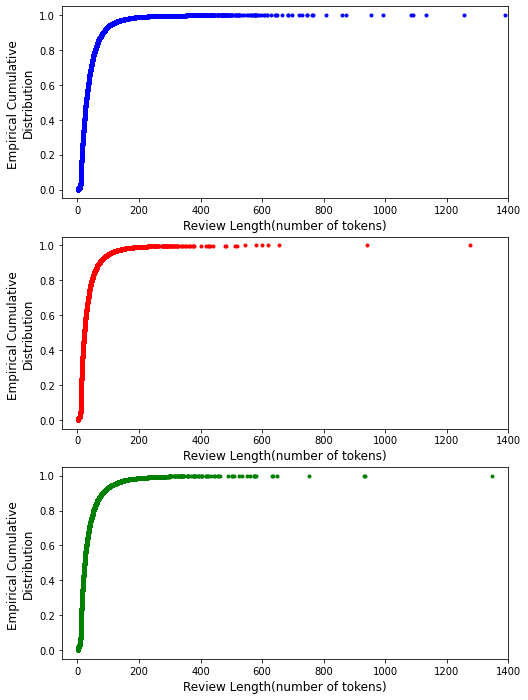

In [89]:
def compute_ecdf(review_list):
    n = len(review_list)
    X = np.sort(review_list)
    y = np.arange(1, n+1)/ n
    return X, y

plt.figure(figsize=(8, 12))


plt.subplot(3,1,1)
x, y = compute_ecdf(train_reviews_len)
plt.plot(x, y, "b.")
plt.xlabel("Review Length(number of tokens)", fontsize=12)
plt.ylabel("Empirical Cumulative \nDistribution", fontsize=12)
plt.xlim(-50, 1400)

plt.subplot(3,1,2)
x, y = compute_ecdf(valid_reviews_len)
plt.plot(x, y, "r.")
plt.xlabel("Review Length(number of tokens)", fontsize=12)
plt.ylabel("Empirical Cumulative \nDistribution", fontsize=12)
plt.xlim(-50, 1400)

plt.subplot(3,1,3)
x, y = compute_ecdf(test_reviews_len)
plt.plot(x, y, "g.")
plt.xlabel("Review Length(number of tokens)", fontsize=12)
plt.ylabel("Empirical Cumulative \nDistribution", fontsize=12)
plt.xlim(-50, 1400)

In [90]:
median_length = int(np.median([len(review) for review in train_reviews]))
median_length

184

In [91]:
pos_freqs, neg_freqs = compute_class_freqs(train_labels)
pos_freqs, neg_freqs

(array([0.16237388, 0.83762612]), array([0.83762612, 0.16237388]))

# Preprocess Data:
* tokenize 
* padding

In [92]:
train_reviews, train_labels = load_dataset("/content/drive/MyDrive/sentiment_analysis/data/processed/train.pkl")
valid_reviews, valid_labels = load_dataset("/content/drive/MyDrive/sentiment_analysis/data/processed/valid.pkl")
test_reviews, test_labels = load_dataset("/content/drive/MyDrive/sentiment_analysis/data/processed/test.pkl")

In [93]:
# Number of words in each review to train on
MAX_LEN = 184

In [94]:


# Instantiate a tokenizer
tokenizer = Tokenizer(num_words=75000, 
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                      lower=True, split=' ', 
                      char_level=False, oov_token='OOV')

# Fit tokennizer on training data
tokenizer.fit_on_texts(train_reviews)

In [ ]:
# saving
with open('/content/drive/MyDrive/sentiment_analysis/data/processed/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [95]:
# loading
with open('/content/drive/MyDrive/sentiment_analysis/data/processed/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [96]:
# Convert is sequences
train_sequences = tokenizer.texts_to_sequences(train_reviews)

# Pad sequences to the length of the longest document
train_padded_seq = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post')

word_index = tokenizer.word_index
print (dict(list(word_index.items())[0:10]))
# Vocabulary Size
vocab_size = len(tokenizer.word_index) + 1
print(f"Size of the corpus vocabulary: {vocab_size} tokens")

{'OOV': 1, 'one': 2, 'baby': 3, 'it': 4, 'great': 5, 'would': 6, 'use': 7, 'like': 8, 'love': 9, 'seat': 10}
Size of the corpus vocabulary: 61256 tokens


In [97]:
print(f"A sample review in the trianing dataset:\n{train_reviews[1]}")
print()
print(f"Number Sequence of the review:\n {train_sequences[1]}")
print()
print(f"Post Padded Sequence:\n {train_padded_seq[1]}")

A sample review in the trianing dataset:
soft comfortable warmer looks...fit full size bed perfectly...would recommend anyone looking type quilt

Number Sequence of the review:
 [71, 109, 695, 134, 42, 371, 63, 157, 213, 6, 35, 297, 129, 633, 2824]

Post Padded Sequence:
 [  71  109  695  134   42  371   63  157  213    6   35  297  129  633
 2824    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  

In [98]:
# Convert is sequences
valid_sequences = tokenizer.texts_to_sequences(valid_reviews)

# Pad sequences to the length of the longest document
valid_padded_seq = pad_sequences(valid_sequences, maxlen=MAX_LEN, padding='post')


In [99]:
# HYPER PARAMETERS
VOCAB_SIZE = vocab_size
EMBED_DIM = 128
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOK = '<OOV>'
MAX_LEN = 184

In [100]:
# Input Directory
input_directory = "/content/drive/MyDrive/sentiment_analysis/input"
if os.path.exists(input_directory):
    print("Input Directory exists")
else:
    os.mkdir(input_directory)

# Output Directory
output_directory = "/content/drive/MyDrive/sentiment_analysis/output/models/saved_models"
if os.path.exists(output_directory):
    print("Output Directory exists")
else:
    os.mkdir(output_directory)

# Figure Directory
figure_directory = "/content/drive/MyDrive/sentiment_analysis/figures"    
if os.path.exists(figure_directory):
    print("Figure Directory exists")
else:
    os.mkdir(figure_directory)

Input Directory exists
Output Directory exists
Figure Directory exists


In [101]:
main_model_dir = output_directory + "models/"
main_log_dir = output_directory + "logs/"

if os.path.exists(main_model_dir):
    print("Main Model Directory exists")
else:
    os.mkdir(main_model_dir)

if os.path.exists(main_log_dir):
    print("Main Log Directory exists")
else:
    os.mkdir(main_log_dir)


model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

if os.path.exists(model_dir):
    print("Model Directory Exists")
else:
    os.mkdir(model_dir)

if os.path.exists(log_dir):
    print("Log Directory Exists")
else:
    os.mkdir(log_dir)

model_file = model_dir + "{epoch:02d}-val_loss-{val_loss:.2f}.hdf5"

Main Model Directory exists
Main Log Directory exists


In [102]:
print("Settings Callbacks")

checkpoint = ModelCheckpoint(
    model_file,
    monitor = 'val_loss',
    save_best_only = True)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    verbose = 1,
    restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(
    monitors = 'val_loss',
    factor = 0.5,
    patience = 1,
    verbose=1)

CALLBACKS = [checkpoint, reduce_lr, early_stopping]

print("Set Callbacks at ", date_time(1))

Settings Callbacks
Set Callbacks at  Timestamp: 2021-01-28 13:30:08


# MODELS

## Model_01 Bidirectional LSTM

In [186]:
def create_bidirectional_LSTM_model(num_class):
    model = Sequential()
   
    model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)))
    for units in [128, 64]:
        model.add(tf.keras.layers.Dense(units, activation = 'relu'))
        model.add(tf.keras.layers.Dropout(0.5))
    
    if num_class>=2:
        model.add(tf.keras.layers.Dense(num_class, activation ='softmax'))
    else:
        model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
    
    model.summary()
    
    return model
        

In [201]:
model_01 = create_bidirectional_LSTM_model(2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 184, 128)          7840768   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 184, 512)          788480    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 512)               1574912   
_________________________________________________________________
dense_19 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)               

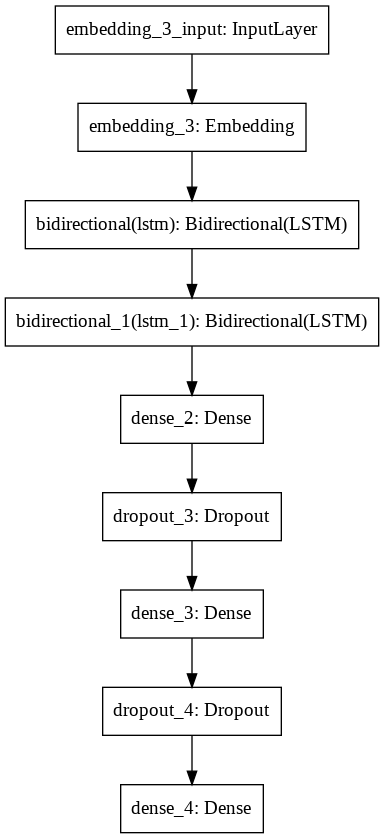

In [105]:
tf.keras.utils.plot_model(model_01)

In [202]:
print("Starting ....\n")

start_time = time.time()
print(date_time(1))


LEARNING_RATE = 1e-3
OPTIMIZER = Adam(LEARNING_RATE)
EPOCHS = 50
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.2

model_01.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer=OPTIMIZER, metrics=["accuracy"])
print("\n \nCompiled the Model....\n")

Starting ....

Timestamp: 2021-01-28 14:35:02

 
Compiled the Model....



In [ ]:
print("Training Model.......\n")

history_01 = model_01.fit(train_padded_seq, 
                          train_labels, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS,
                          callbacks=CALLBACKS,
                          validation_split=VALIDATION_SPLIT,
                          #class_weight=class_weights,
                          verbose=1)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))


Training Model.......

Epoch 1/50
417/417 [==============================] - 102s 244ms/step - loss: 0.1995 - accuracy: 0.8341 - val_loss: 0.1470 - val_accuracy: 0.8708
Epoch 2/50
417/417 [==============================] - 99s 238ms/step - loss: 0.1203 - accuracy: 0.9082 - val_loss: 0.1452 - val_accuracy: 0.8861
Epoch 3/50
417/417 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9341
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
417/417 [==============================] - 98s 236ms/step - loss: 0.0885 - accuracy: 0.9341 - val_loss: 0.1740 - val_accuracy: 0.8909
Epoch 4/50
417/417 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9579
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
417/417 [==============================] - 99s 236ms/step - loss: 0.0580 - accuracy: 0.9579 - val_loss: 0.2129 - val_accuracy: 0.9019
Epoch 5/50
417/417 [==============================] - ETA: 0s - lo

In [ ]:
model_01.save("/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_01.h5")

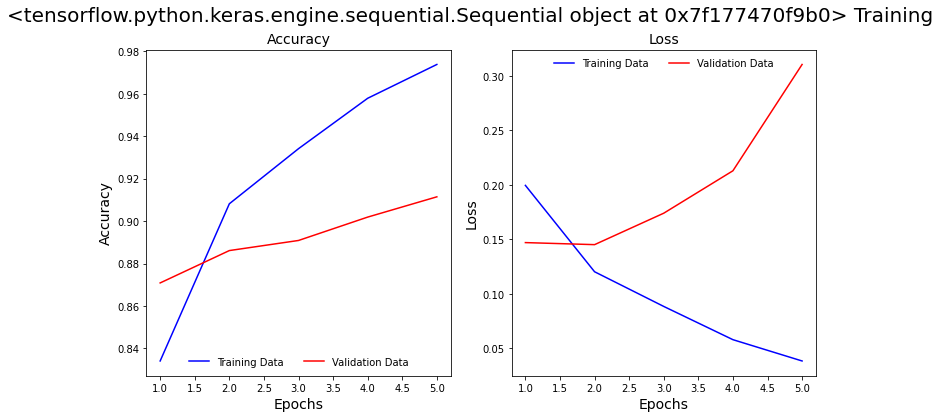

In [ ]:
plot_performance(history_01, model_01)

### Model Evaluation

1.   Load the model without compiling it. 
2.   Initialize the loss functions that was used during model training.
3.   Compile the model now for evaluation.


In [107]:
# Load the model
model_01 = tf.keras.models.load_model('/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_01.h5', compile=False)

# list the loss function
losses = get_weighted_loss(pos_weights, neg_weights)

# compile and train the model
model_01.compile(optimizer='adam', loss=losses, metrics=['accuracy'])

In [108]:
# evaluate model on training dataset
loss, acc = model_01.evaluate(train_padded_seq, train_labels, verbose=0)
print('Train Accuracy: %f' % (acc*100))
 
# evaluate model on test dataset dataset
val_loss, val_acc = model_01.evaluate(valid_padded_seq, valid_labels, verbose=0)
print('Test Accuracy: %f' % (val_acc*100))


Train Accuracy: 91.958892
Test Accuracy: 89.079458


In [109]:
print(f"-"*55)
print(f"-----------------Model-01 Evaluation-------------------")
print(f"-"*55)
print(f"|            |     Training        |      Test         |")
print(f"|            |       Data          |      Data         |")
print(f"-"*55)
print(f"| Accuracy   |       {round(acc, 3)}          |      {round(loss, 3)}        |")
print(f"-"*55)
print(f"| Loss       |       {round(val_acc, 3)}         |      {round(val_loss, 3)}         |")
print(f"-"*55)

-------------------------------------------------------
-----------------Model-01 Evaluation-------------------
-------------------------------------------------------
|            |     Training        |      Test         |
|            |       Data          |      Data         |
-------------------------------------------------------
| Accuracy   |       0.92          |      0.097        |
-------------------------------------------------------
| Loss       |       0.891         |      0.14         |
-------------------------------------------------------


In [110]:
test_review_01 = [test_reviews[0]]
test_label_01 = [test_labels[0]]
print(f"{test_label_01} \t {test_review_01}")

[array([0., 1.], dtype=float32)] 	 ['Prefect, looking for.']


In [111]:
test_review_02 = [test_reviews[10]]
test_label_02 = [test_labels[10]]
print(f"{test_label_02} \t {test_review_02}")

[array([0., 1.], dtype=float32)] 	 ['baby sensitive skin, took find good quality Blankets Hankies. like comes pack two leave one home keep one diaper bag.']



['baby sensitive skin, took find good quality Blankets Hankies. like comes pack two leave one home keep one diaper bag.']

In [198]:

test_01 =  ['Prefect, looking for.']
print(f"Positive Review: {test_01}\n")
test_02 = ["could n't even take seat zip lock bag came box . smelled like horrible toxic fumes . ordered blue one white came straight box zip lock n't recall smell . went smell faint press nose . love blue one , comfy special needs little girl five size two yr old . unfortunately return white one sad wanted one bathroom : - ( perhaps border another colored one like pink next time . amazon great band refunded . mail straight box zip lock . called dream baby company said ship seats zip lock son guess makes sense bit stank bad ! wish could make stuff less chemicals . overall , softest comfiest cushion potty seat feel ... purchase another cross fingers wo n't zip lock ; - )"]
print(f"Negative Review: {test_02}")

Positive Review: ['Prefect, looking for.']

Negative Review: ["could n't even take seat zip lock bag came box . smelled like horrible toxic fumes . ordered blue one white came straight box zip lock n't recall smell . went smell faint press nose . love blue one , comfy special needs little girl five size two yr old . unfortunately return white one sad wanted one bathroom : - ( perhaps border another colored one like pink next time . amazon great band refunded . mail straight box zip lock . called dream baby company said ship seats zip lock son guess makes sense bit stank bad ! wish could make stuff less chemicals . overall , softest comfiest cushion potty seat feel ... purchase another cross fingers wo n't zip lock ; - )"]


In [203]:
def test_sentiment(test_text, trained_tokenizer, model, max_length):
  """
  test_text: str -  Review to test
  trained_tokenizer: - Tokenizer trained on training set
  model: str - path to the trained model
  max_length: int - max length of the trained reviews
  """
  #1.  Load the trained tokenizer
  tokenizer = trained_tokenizer
  #2. Convert text to sequence
  sequence = tokenizer.texts_to_sequences(test_text)
  #3. Pad sequence
  padded = pad_sequences(sequence, maxlen=max_length)
  #4. Load model
  model = tf.keras.models.load_model(model, compile=False)
  #5. Prediction probabilities
  pred_proba = model.predict(padded)
  #6. Sentiment
  sentiments = ["Negative", "Positive"]
  predicted_sentiment = sentiments[np.argmax(pred_proba)]

  
  return pred_proba, predicted_sentiment


In [114]:
with open('/content/drive/MyDrive/sentiment_analysis/data/processed/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

test_text = [test_reviews[0]]

max_length = 184

In [206]:
model_path = '/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_01.h5'

In [207]:
pred_proba, predicted_sentiment = test_sentiment(test_text=test_text, trained_tokenizer = tokenizer, model=model_path, max_length=184)
print(pred_proba)
print(predicted_sentiment)

[[0.648785   0.35121506]]
Negative


## Model-02 CNN

In [116]:
def create_cnn_model(num_class):   
    model = Sequential()
    
    model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN))
    
    model.add(tf.keras.layers.Conv1D(1024, 3, padding='valid', activation='relu', strides=1))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(2048, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    
    if num_class>=2:
        model.add(tf.keras.layers.Dense(num_class, activation='softmax'))
    else:
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.summary()
    return model

In [117]:
num_class = 2
model_02 = create_cnn_model(num_class)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 184, 128)          7840768   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 182, 1024)         394240    
_________________________________________________________________
global_max_pooling1d (Global (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)             

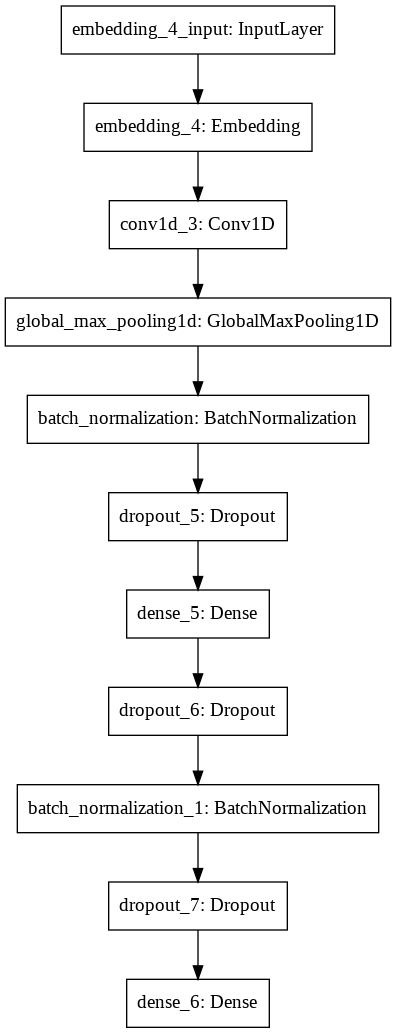

In [118]:
tf.keras.utils.plot_model(model_02)

In [ ]:
print("Starting ....\n")

start_time = time.time()
print(date_time(1))

print("\n \nCompiling the Model....\n")
LEARNING_RATE = 1e-3
OPTIMIZER = Adam(LEARNING_RATE)
EPOCHS = 20
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.2

model_02.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer=OPTIMIZER, metrics=["accuracy"])

print("Training Model.......\n")

history_02 = model_02.fit(train_padded_seq, 
                          train_labels, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS,
                          callbacks=CALLBACKS,
                          validation_split=VALIDATION_SPLIT,
                          #class_weight=class_weights,
                          verbose=1)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))


Starting ....

Timestamp: 2020-12-16 15:30:29

 
Compiling the Model....

Training Model.......

Epoch 1/20
417/417 [==============================] - 36s 86ms/step - loss: 0.2594 - accuracy: 0.7969 - val_loss: 0.2733 - val_accuracy: 0.8992
Epoch 2/20
417/417 [==============================] - 36s 87ms/step - loss: 0.1261 - accuracy: 0.9052 - val_loss: 0.1496 - val_accuracy: 0.9110
Epoch 3/20
417/417 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.9346
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
417/417 [==============================] - 36s 86ms/step - loss: 0.0910 - accuracy: 0.9346 - val_loss: 0.1727 - val_accuracy: 0.9011
Epoch 4/20
417/417 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9644
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
417/417 [==============================] - 36s 86ms/step - loss: 0.0511 - accuracy: 0.9644 - val_loss: 0.2130 - val_accuracy: 0.92

In [ ]:
model_02.save("/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_02.h5")

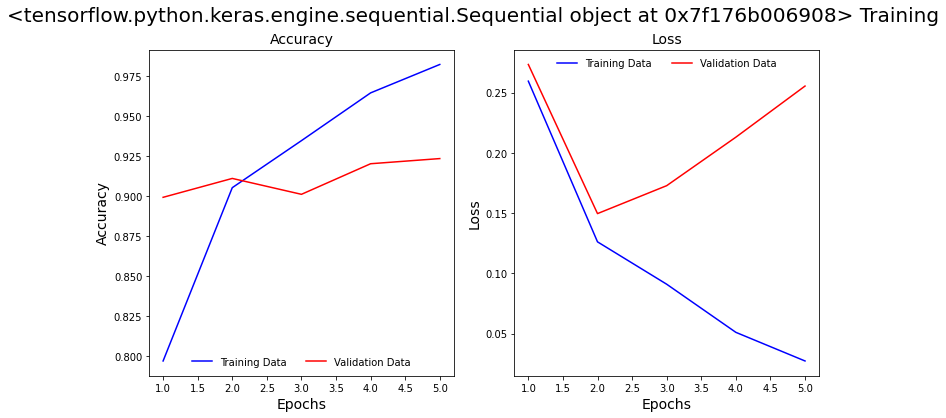

In [ ]:
plot_performance(history_02, model_02)

### Model Evaluation

In [119]:
# Load the model
model_02 = tf.keras.models.load_model('/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_02.h5', compile=False)
# list the loss function
losses = get_weighted_loss(pos_weights, neg_weights)
# compile and train the model
model_02.compile(optimizer='adam', loss=losses, metrics=['accuracy'])

# evaluate model on training dataset
loss_02, acc_02 = model_02.evaluate(train_padded_seq, train_labels, verbose=0)
print('Train Accuracy: %f' % (acc*100))
# evaluate model on test dataset dataset
val_loss_02, val_acc_02 = model_02.evaluate(valid_padded_seq, valid_labels, verbose=0)
print('Test Accuracy: %f' % (val_acc*100))


print(f"-"*55)
print(f"-----------------Model-02 Evaluation-------------------")
print(f"-"*55)
print(f"|            |     Training        |      Test         |")
print(f"|            |       Data          |      Data         |")
print(f"-"*55)
print(f"| Accuracy   |       {round(acc_02, 3)}          |      {round(loss_02, 3)}        |")
print(f"-"*55)
print(f"| Loss       |       {round(val_acc_02, 3)}         |      {round(val_loss_02, 3)}         |")
print(f"-"*55)

Train Accuracy: 91.958892
Test Accuracy: 89.079458
-------------------------------------------------------
-----------------Model-02 Evaluation-------------------
-------------------------------------------------------
|            |     Training        |      Test         |
|            |       Data          |      Data         |
-------------------------------------------------------
| Accuracy   |       0.952          |      0.074        |
-------------------------------------------------------
| Loss       |       0.912         |      0.143         |
-------------------------------------------------------


In [183]:
model_path='/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_02.h5'

In [121]:
pred_proba, predicted_sentiment = test_sentiment(test_text=test_text, trained_tokenizer = tokenizer, model=model_path, max_length=184)
print(pred_proba)
print(predicted_sentiment)

[[1.5969876e-04 9.9984026e-01]]
Positive


## Model 04

In [122]:
def create_multibranch_CNN(length, vocab_size, num_class):
    """
    define three different CNN architectures using Functional API
    Each CNN uses kernels of different sizes: 4,6,8
    Args:
    length - length of the input data for example length of the input sequence
    vocab_size - Size of the vocabulary - with Tokenizer it's len of the word_index + 1
    num_class - number of classes the model is trying to classify.
    
    """
    #branch 01
    inputs_01 = tf.keras.layers.Input(shape=(length, ))                               # max length of the input data
    embedding_01 = Embedding(VOCAB_SIZE, EMBED_DIM)(inputs_01)
    conv_01 = tf.keras.layers.Conv1D(filters=256, kernel_size=4, activation='relu')(embedding_01)
    drop_01 = tf.keras.layers.Dropout(0.5)(conv_01)
    pool_01 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop_01)
    flat_01 = tf.keras.layers.Flatten()(pool_01)
    
    #branch 02
    inputs_02 = tf.keras.layers.Input(shape=(length, ))
    embedding_02 = Embedding(VOCAB_SIZE, EMBED_DIM)(inputs_02)
    conv_02 = tf.keras.layers.Conv1D(filters=256, kernel_size=8, activation='relu')(embedding_02)
    drop_02 = tf.keras.layers.Dropout(0.5)(conv_02)
    pool_02 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop_02)
    flat_02 = tf.keras.layers.Flatten()(pool_02)
    
    #branch 03
    inputs_03 = tf.keras.layers.Input(shape=(length, ))
    embedding_03 = Embedding(VOCAB_SIZE, EMBED_DIM)(inputs_03)
    conv_03 = tf.keras.layers.Conv1D(filters=128, kernel_size=11, activation='relu')(embedding_03)
    drop_03 = tf.keras.layers.Dropout(0.5)(conv_03)
    pool_03 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop_03)
    flat_03 = tf.keras.layers.Flatten()(pool_03)
    
    #merge
    merged = tf.keras.layers.concatenate([flat_01, flat_02, flat_03])
    
    # interpretation
    dense_01 = tf.keras.layers.Dense(200, activation='relu')(merged)
    
    if num_class>2:
        outputs = tf.keras.layers.Dense(num_class, activation='softmax')(dense_01)
    else:
        outputs = tf.keras.layers.Dense(num_class, activation='sigmoid')(dense_01)
    
    model = tf.keras.Model(inputs=[inputs_01, inputs_02, inputs_03], outputs=outputs)
    
    # compile
#     model.compile(loss = get_weighted_loss(pos_weights, neg_weights), optimizer='adam', metrics = ['accuracy'])
    
    print(model.summary())
    
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [123]:
num_class = 2
model_04 = create_multibranch_CNN(MAX_LEN, VOCAB_SIZE, 2)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 184)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 184)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 184)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 184, 128)     7840768     input_4[0][0]                    
____________________________________________________________________________________________

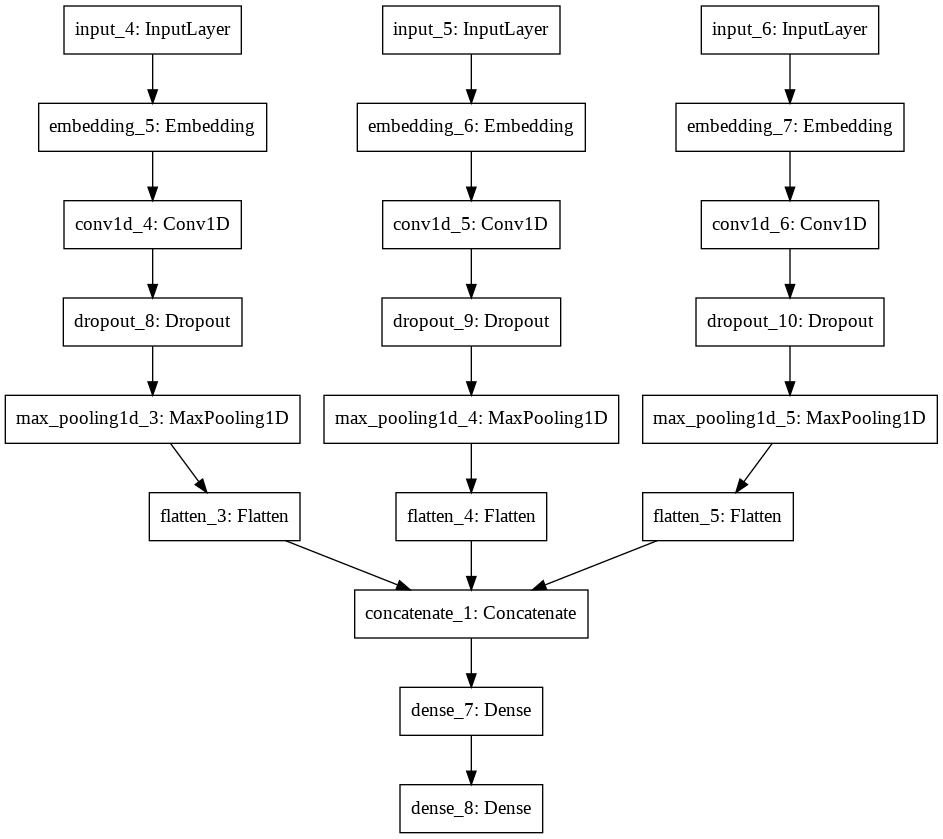

In [124]:
tf.keras.utils.plot_model(model_04)

In [125]:
print("Starting ....\n")

start_time = time.time()
print(date_time(1))

print("\n \nCompiling the Model....\n")
LEARNING_RATE = 1e-2
OPTIMIZER = Adam(LEARNING_RATE)
EPOCHS = 50
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2

model_04.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer=OPTIMIZER, metrics=["accuracy"])


Starting ....

Timestamp: 2021-01-28 13:36:50

 
Compiling the Model....



In [ ]:

print("Training Model.......\n")

history_04 = model_04.fit([train_padded_seq,train_padded_seq,train_padded_seq], 
                          train_labels, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS,
                          callbacks=CALLBACKS,
                          validation_split=VALIDATION_SPLIT,
                          #class_weight=class_weights,
                          verbose=1)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))


Starting ....

Timestamp: 2020-12-16 15:43:32

 
Compiling the Model....

Training Model.......

Epoch 1/50
834/834 [==============================] - 145s 174ms/step - loss: 4.4287 - accuracy: 0.8354 - val_loss: 4.1591 - val_accuracy: 0.8458
Epoch 2/50
834/834 [==============================] - ETA: 0s - loss: 4.4336 - accuracy: 0.8356
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
834/834 [==============================] - 146s 175ms/step - loss: 4.4336 - accuracy: 0.8356 - val_loss: 4.1591 - val_accuracy: 0.8458
Epoch 3/50
834/834 [==============================] - ETA: 0s - loss: 4.4336 - accuracy: 0.8356
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
834/834 [==============================] - 146s 175ms/step - loss: 4.4336 - accuracy: 0.8356 - val_loss: 4.1591 - val_accuracy: 0.8458
Epoch 4/50
834/834 [==============================] - ETA: 0s - loss: 4.4336 - accuracy: 0.8356
Epoch 00004: ReduceLROnPlateau reducing 

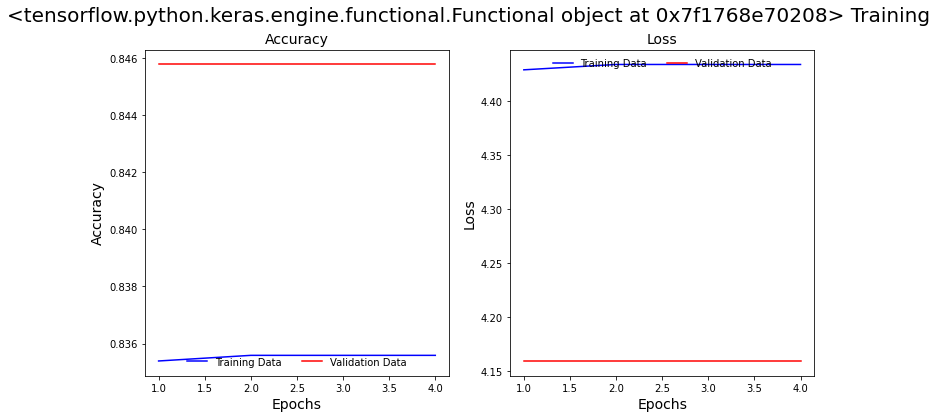

In [ ]:
plot_performance(history_04, model_04)

In [185]:
model_04.save("/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_04.h5")#

In [128]:
# Load the model
model_04 = tf.keras.models.load_model("/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_04.h5", compile=False)
# list the loss function
losses = get_weighted_loss(pos_weights, neg_weights)
# compile and train the model
model_04.compile(optimizer='adam', loss=losses, metrics=['accuracy'])

# evaluate model on training dataset
loss_04, acc_04 = model_04.evaluate([train_padded_seq, train_padded_seq, train_padded_seq], train_labels, verbose=0)
print('Train Accuracy: %f' % (acc*100))
# evaluate model on test dataset dataset
val_loss_04, val_acc_04 = model_04.evaluate([valid_padded_seq, valid_padded_seq, valid_padded_seq], valid_labels, verbose=0)
print('Test Accuracy: %f' % (val_acc*100))


print(f"-"*55)
print(f"-----------------Model-04 Evaluation-------------------")
print(f"-"*55)
print(f"|            |     Training        |      Test         |")
print(f"|            |       Data          |      Data         |")
print(f"-"*55)
print(f"| Accuracy   |       {round(acc_04, 3)}          |      {round(loss_04, 3)}        |")
print(f"-"*55)
print(f"| Loss       |       {round(val_acc_04, 3)}         |      {round(val_loss_04, 3)}         |")
print(f"-"*55)

Train Accuracy: 91.958892
Test Accuracy: 89.079458
-------------------------------------------------------
-----------------Model-04 Evaluation-------------------
-------------------------------------------------------
|            |     Training        |      Test         |
|            |       Data          |      Data         |
-------------------------------------------------------
| Accuracy   |       0.838          |      4.379        |
-------------------------------------------------------
| Loss       |       0.854         |      3.948         |
-------------------------------------------------------


In [208]:
model_path='/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_04.h5'

In [210]:
pred_proba, predicted_sentiment = test_sentiment(test_text=[test_text, test_text, test_text], trained_tokenizer = tokenizer, model=model_path, max_length=184)
print(pred_proba)
print(predicted_sentiment)

## Model_05

In [133]:
def create_LSTM_model(num_classes):
    model = Sequential()
    model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(tf.keras.layers.Dense(num_classes, activation ='softmax'))
    model.summary()
    return model
      

In [134]:
num_classes = 2
model_05 = create_LSTM_model(num_classes)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 184, 128)          7840768   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 184, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 202       
Total params: 7,932,570
Trainable params: 7,932,570
Non-trainable params: 0
_________________________________________________________________


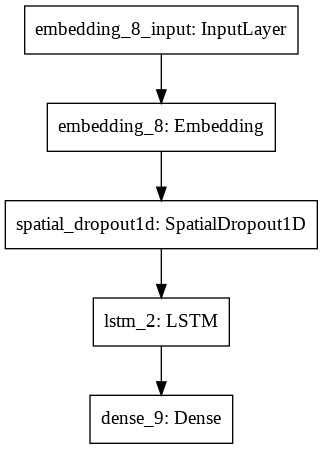

In [135]:
tf.keras.utils.plot_model(model_05)

In [136]:
print("Starting ....\n")

start_time = time.time()
print(date_time(1))

print("\n \nCompiling the Model....\n")
LEARNING_RATE = 1e-2
OPTIMIZER = Adam(LEARNING_RATE)
EPOCHS = 50
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2

model_05.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer=OPTIMIZER, metrics=["accuracy"])
print("Model Compiled....\n")

Starting ....

Timestamp: 2021-01-28 13:41:54

 
Compiling the Model....

Model Compiled....



In [ ]:


print("Training Model.......\n")

history_05 = model_05.fit(train_padded_seq, 
                          train_labels, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS,
                          callbacks=CALLBACKS,
                          validation_split=VALIDATION_SPLIT,
                          #class_weight=class_weights,
                          verbose=1)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))


Starting ....

Timestamp: 2020-12-16 15:53:21

 
Compiling the Model....

Model Compiled....

Training Model.......

Epoch 1/50
834/834 [==============================] - 763s 915ms/step - loss: 0.3762 - accuracy: 0.3370 - val_loss: 0.3816 - val_accuracy: 0.1544
Epoch 2/50
834/834 [==============================] - 765s 918ms/step - loss: 0.3728 - accuracy: 0.3980 - val_loss: 0.3245 - val_accuracy: 0.6706
Epoch 3/50
834/834 [==============================] - 770s 923ms/step - loss: 0.2791 - accuracy: 0.7702 - val_loss: 0.2485 - val_accuracy: 0.7978
Epoch 4/50
834/834 [==============================] - 766s 918ms/step - loss: 0.2546 - accuracy: 0.7892 - val_loss: 0.2373 - val_accuracy: 0.8148
Epoch 5/50
834/834 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.8033
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
834/834 [==============================] - 761s 912ms/step - loss: 0.2411 - accuracy: 0.8033 - val_loss: 0.2430 - val_accura

In [ ]:
model_05.save("/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_05.h5")

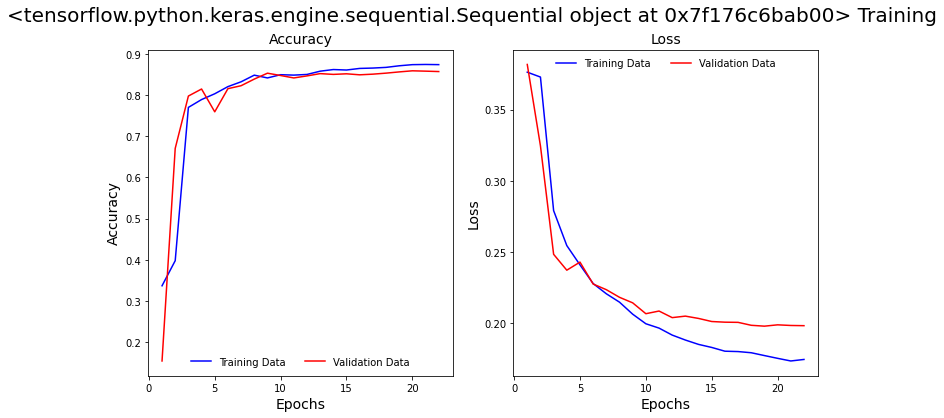

In [ ]:
plot_performance(history_05, model_05)

In [137]:
# Load the model
model_05 = tf.keras.models.load_model('/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_05.h5', compile=False)
# list the loss function
losses = get_weighted_loss(pos_weights, neg_weights)
# compile and train the model
model_05.compile(optimizer='adam', loss=losses, metrics=['accuracy'])

# evaluate model on training dataset
loss_05, acc_05 = model_05.evaluate(train_padded_seq, train_labels, verbose=0)
print('Train Accuracy: %f' % (acc*100))
# evaluate model on test dataset dataset
val_loss_05, val_acc_05 = model_05.evaluate(valid_padded_seq, valid_labels, verbose=0)
print('Test Accuracy: %f' % (val_acc*100))


print(f"-"*55)
print(f"-----------------Model-05 Evaluation-------------------")
print(f"-"*55)
print(f"|            |     Training        |      Test         |")
print(f"|            |       Data          |      Data         |")
print(f"-"*55)
print(f"| Accuracy   |       {round(acc_05, 3)}          |      {round(loss_05, 3)}        |")
print(f"-"*55)
print(f"| Loss       |       {round(val_acc_05, 3)}         |      {round(val_loss_05, 3)}         |")
print(f"-"*55)

Train Accuracy: 91.958892
Test Accuracy: 89.079458
-------------------------------------------------------
-----------------Model-05 Evaluation-------------------
-------------------------------------------------------
|            |     Training        |      Test         |
|            |       Data          |      Data         |
-------------------------------------------------------
| Accuracy   |       0.876          |      0.168        |
-------------------------------------------------------
| Loss       |       0.864         |      0.188         |
-------------------------------------------------------


In [138]:
model_path='/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_05.h5'

In [139]:
pred_proba, predicted_sentiment = test_sentiment(test_text=[test_text, test_text, test_text], trained_tokenizer = tokenizer, model=model_path, max_length=184)
print(pred_proba)
print(predicted_sentiment)

[[0.30895194 0.6910481 ]
 [0.30895194 0.6910481 ]
 [0.30895194 0.6910481 ]]
Positive


## Model_06 - Bidirectional_LSTM

In [140]:
def create_Bidirectional_LSTM_model(num_classes):
    model = Sequential()
    model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    model.add(Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model

model_06 =  create_Bidirectional_LSTM_model(num_classes=2)   

In [141]:
model_06.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 184, 128)          7840768   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 184, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               183200    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 402       
Total params: 8,024,370
Trainable params: 8,024,370
Non-trainable params: 0
_________________________________________________________________


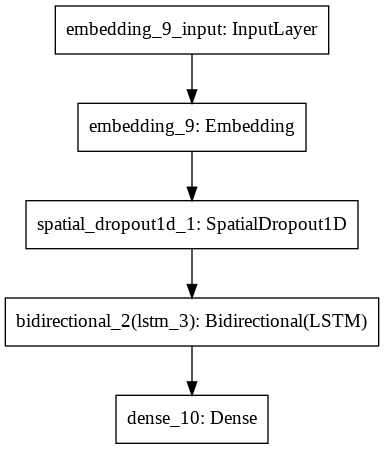

In [142]:
tf.keras.utils.plot_model(model_06)

In [143]:
print("Starting ....\n")

start_time = time.time()
print(date_time(1))

print("\n \nCompiling the Model....\n")
LEARNING_RATE = 1e-2
OPTIMIZER = Adam(LEARNING_RATE)
EPOCHS = 50
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2

model_06.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer=OPTIMIZER, metrics=["accuracy"])
print("Model Compiled....\n")




Starting ....

Timestamp: 2021-01-28 13:48:26

 
Compiling the Model....

Model Compiled....



In [ ]:
print("Training Model.......\n")
history_06 = model_06.fit(train_padded_seq, 
                          train_labels, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS,
                          callbacks=CALLBACKS,
                          validation_split=VALIDATION_SPLIT,
                          #class_weight=class_weights,
                          verbose=1)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))


Starting ....

Timestamp: 2020-12-16 20:43:41

 
Compiling the Model....

Model Compiled....

Training Model.......

Epoch 1/50
834/834 [==============================] - 1475s 2s/step - loss: 0.1834 - accuracy: 0.8478 - val_loss: 0.1524 - val_accuracy: 0.9141
Epoch 2/50
834/834 [==============================] - 1474s 2s/step - loss: 0.1184 - accuracy: 0.9095 - val_loss: 0.1491 - val_accuracy: 0.8929
Epoch 3/50
834/834 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9277
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
834/834 [==============================] - 1475s 2s/step - loss: 0.0964 - accuracy: 0.9277 - val_loss: 0.1681 - val_accuracy: 0.8930
Epoch 4/50
834/834 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9454
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
834/834 [==============================] - 1461s 2s/step - loss: 0.0717 - accuracy: 0.9454 - val_loss: 0.1852 -

In [ ]:
model_06.save("/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_06.h5")

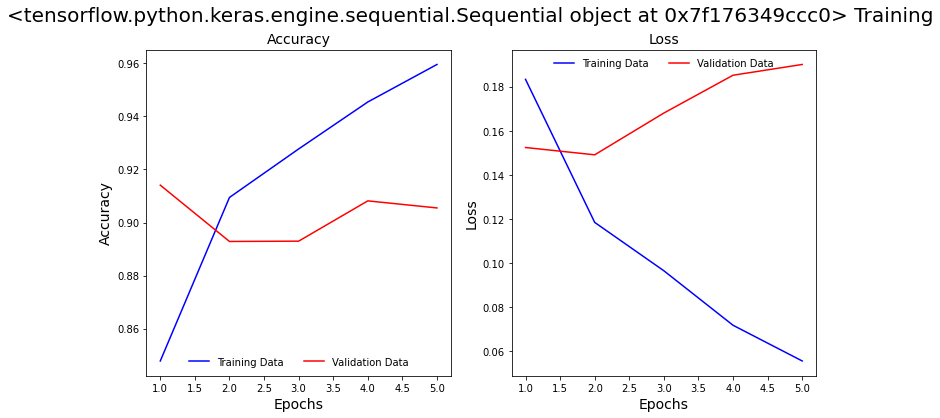

In [ ]:
plot_performance(history_06, model_06)

In [144]:
# Load the model
model_06 = tf.keras.models.load_model('/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_06.h5', compile=False)
# list the loss function
losses = get_weighted_loss(pos_weights, neg_weights)
# compile and train the model
model_06.compile(optimizer='adam', loss=losses, metrics=['accuracy'])

# evaluate model on training dataset
loss_06, acc_06 = model_06.evaluate(train_padded_seq, train_labels, verbose=0)
print('Train Accuracy: %f' % (acc_06*100))
# evaluate model on test dataset dataset
val_loss_06, val_acc_06 = model_06.evaluate(valid_padded_seq, valid_labels, verbose=0)
print('Test Accuracy: %f' % (val_acc_06*100))


print(f"-"*55)
print(f"-----------------Model-05 Evaluation-------------------")
print(f"-"*55)
print(f"|            |     Training        |      Test         |")
print(f"|            |       Data          |      Data         |")
print(f"-"*55)
print(f"| Accuracy   |       {round(acc_06, 3)}          |      {round(loss_06, 3)}        |")
print(f"-"*55)
print(f"| Loss       |       {round(val_acc_06, 3)}         |      {round(val_loss_06, 3)}         |")
print(f"-"*55)

Train Accuracy: 92.360681
Test Accuracy: 89.685160
-------------------------------------------------------
-----------------Model-05 Evaluation-------------------
-------------------------------------------------------
|            |     Training        |      Test         |
|            |       Data          |      Data         |
-------------------------------------------------------
| Accuracy   |       0.924          |      0.097        |
-------------------------------------------------------
| Loss       |       0.897         |      0.139         |
-------------------------------------------------------


In [194]:
model_path='/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_06.h5'

In [195]:
pred_proba, predicted_sentiment = test_sentiment(test_text=test_text, trained_tokenizer = tokenizer, model=model_path, max_length=184)
print(pred_proba)
print(predicted_sentiment)

[[0.33184007 0.66815996]]
Positive


In [196]:
pred_proba_01, predicted_sentiment_01 = test_sentiment(test_text=[test_01], trained_tokenizer = tokenizer, model=model_path, max_length=184)
print(f"Predicted Probability: {pred_proba_01}")
print(predicted_sentiment_01)
print(f"Test Review 1:\t True Label Positive Sentiment \t Predicted Label: {predicted_sentiment_01}")
print()

pred_proba_02, predicted_sentiment_02 = test_sentiment(test_text=[test_02], trained_tokenizer = tokenizer, model=model_path, max_length=184)
print(f"Predicted Probability: {pred_proba_02}")
print(predicted_sentiment_02)
print(f"Test Review 1:\t True Label Positive Sentiment \t Predicted Label: {predicted_sentiment_02}")

Predicted Probability: [[0.36334962 0.63665044]]
Positive
Test Review 1:	 True Label Positive Sentiment 	 Predicted Label: Positive

Predicted Probability: [[0.36334962 0.63665044]]
Positive
Test Review 1:	 True Label Positive Sentiment 	 Predicted Label: Positive


In [193]:
test_text

['Prefect, looking for.']

In [ ]:
conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(input_data)
    # Add batch normalization
    bn_cnn = BatchNormalization(name='bn_conv_1d')(conv_1d)

## Model_07 1D-CNN BiDirectional LSTM

In [147]:
def create_cnn_bidirectional_LSTM_model(num_class):
    model = Sequential()
   
    model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN))
    model.add(tf.keras.layers.Conv1D(256, kernel_size=8, strides=2, padding="valid",
                     activation='relu', name='conv1d'))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)))
    for units in [128, 64]:
        model.add(tf.keras.layers.Dense(units, activation = 'relu'))
        model.add(tf.keras.layers.Dropout(0.5))
    
    if num_class>=2:
        model.add(tf.keras.layers.Dense(num_class, activation ='softmax'))
    else:
        model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
    
    model.summary()
    
    return model
        

In [148]:
model_07 = create_cnn_bidirectional_LSTM_model(num_class=2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 184, 128)          7840768   
_________________________________________________________________
conv1d (Conv1D)              (None, 89, 256)           262400    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 89, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 89, 512)           1050624   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

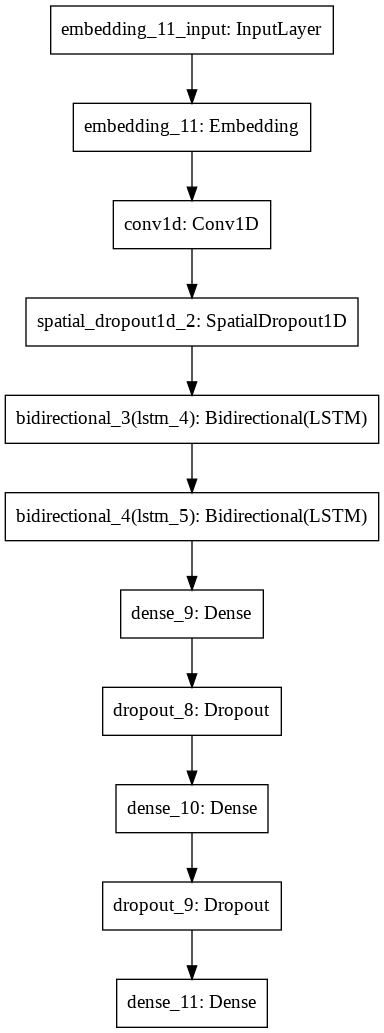

In [ ]:
tf.keras.utils.plot_model(model_07)

In [149]:
print("Starting ....\n")

start_time = time.time()
print(date_time(1))

print("\n \nCompiling the Model....\n")
LEARNING_RATE = 1e-2
OPTIMIZER = Adam(LEARNING_RATE)
EPOCHS = 50
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2

model_07.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer=OPTIMIZER, metrics=["accuracy"])
print("Model Compiled....\n")

Starting ....

Timestamp: 2021-01-28 13:59:07

 
Compiling the Model....

Model Compiled....



In [ ]:


print("Training Model.......\n")

history_07 = model_07.fit(train_padded_seq, 
                          train_labels, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS,
                          callbacks=CALLBACKS,
                          validation_split=VALIDATION_SPLIT,
                          #class_weight=class_weights,
                          verbose=1)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))


Starting ....

Timestamp: 2020-12-16 22:46:27

 
Compiling the Model....

Model Compiled....

Training Model.......

Epoch 1/50
834/834 [==============================] - 96s 115ms/step - loss: 0.3786 - accuracy: 0.2953 - val_loss: 0.3662 - val_accuracy: 0.1542
Epoch 2/50
834/834 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.3083
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
834/834 [==============================] - 94s 113ms/step - loss: 0.3758 - accuracy: 0.3083 - val_loss: 0.3664 - val_accuracy: 0.1542
Epoch 3/50
834/834 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.2902
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
834/834 [==============================] - 94s 113ms/step - loss: 0.3757 - accuracy: 0.2902 - val_loss: 0.3662 - val_accuracy: 0.1542
Epoch 4/50
834/834 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.1845
Epoch 00004: ReduceLROn

In [ ]:
model_07.save("/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_07.h5")

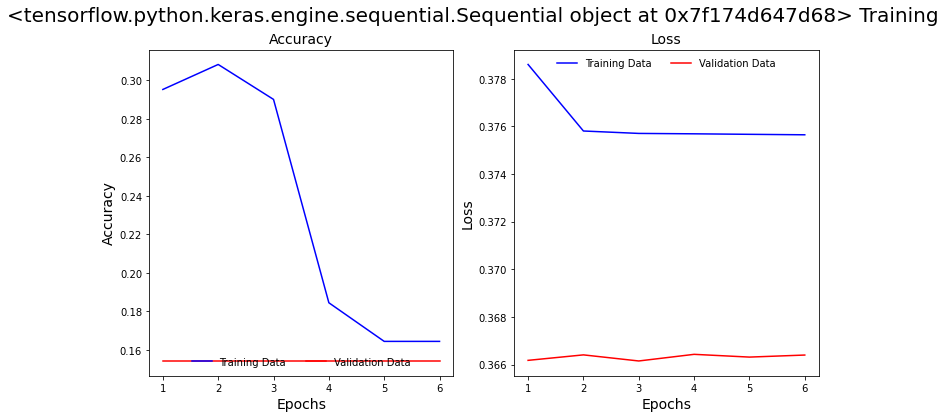

In [ ]:
plot_performance(history_07, model_07)

In [150]:
# Load the model
model_07 = tf.keras.models.load_model('/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_07.h5', compile=False)
# list the loss function
losses = get_weighted_loss(pos_weights, neg_weights)
# compile and train the model
model_07.compile(optimizer='adam', loss=losses, metrics=['accuracy'])

# evaluate model on training dataset
loss_07, acc_07 = model_07.evaluate(train_padded_seq, train_labels, verbose=0)
print('Train Accuracy: %f' % (acc_07*100))
# evaluate model on test dataset dataset
val_loss_07, val_acc_07 = model_07.evaluate(valid_padded_seq, valid_labels, verbose=0)
print('Test Accuracy: %f' % (val_acc_07*100))


print(f"-"*55)
print(f"-----------------Model-07 Evaluation-------------------")
print(f"-"*55)
print(f"|            |     Training        |      Test         |")
print(f"|            |       Data          |      Data         |")
print(f"-"*55)
print(f"| Accuracy   |       {round(acc_07, 3)}          |      {round(loss_07, 3)}        |")
print(f"-"*55)
print(f"| Loss       |       {round(val_acc_07, 3)}         |      {round(val_loss_07, 3)}         |")
print(f"-"*55)

Train Accuracy: 16.237387
Test Accuracy: 14.638680
-------------------------------------------------------
-----------------Model-07 Evaluation-------------------
-------------------------------------------------------
|            |     Training        |      Test         |
|            |       Data          |      Data         |
-------------------------------------------------------
| Accuracy   |       0.162          |      0.374        |
-------------------------------------------------------
| Loss       |       0.146         |      0.359         |
-------------------------------------------------------


In [151]:
model_path='/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_07.h5'

In [152]:
pred_proba, predicted_sentiment = test_sentiment(test_text=test_text, trained_tokenizer = tokenizer, model=model_path, max_length=184)
print(pred_proba)
print(predicted_sentiment)

[[0.5016094  0.49839064]]
Negative


## Model-08 CNN_Bidirectional_LSTM_model_02

In [153]:
def create_cnn_bidirectional_LSTM_model_02(num_class):
    model = Sequential()
   
    model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    model.add(tf.keras.layers.Conv1D(256, kernel_size=8, strides=2, padding="valid",
                     activation='relu', name='conv1d'))
    model.add(tf.keras.layers.BatchNormalization(name='bn_conv_1d'))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)))
    for idx, units in enumerate([128, 64]):
        model.add(tf.keras.layers.Dense(units, activation = 'relu', name=f'dense_{idx}'))
        model.add(tf.keras.layers.BatchNormalization(name=f'bn_dense_{idx}'))
        model.add(tf.keras.layers.Dropout(0.5))
    
    if num_class>=2:
        model.add(tf.keras.layers.Dense(num_class, activation ='softmax'))
    else:
        model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
    
    model.summary()
    
    return model
        

In [155]:
model_08 = create_cnn_bidirectional_LSTM_model_02(num_class=2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 184, 128)          7840768   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 184, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 89, 256)           262400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, 89, 256)           1024      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 89, 512)           1050624   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense_0 (Dense)              (None, 128)              

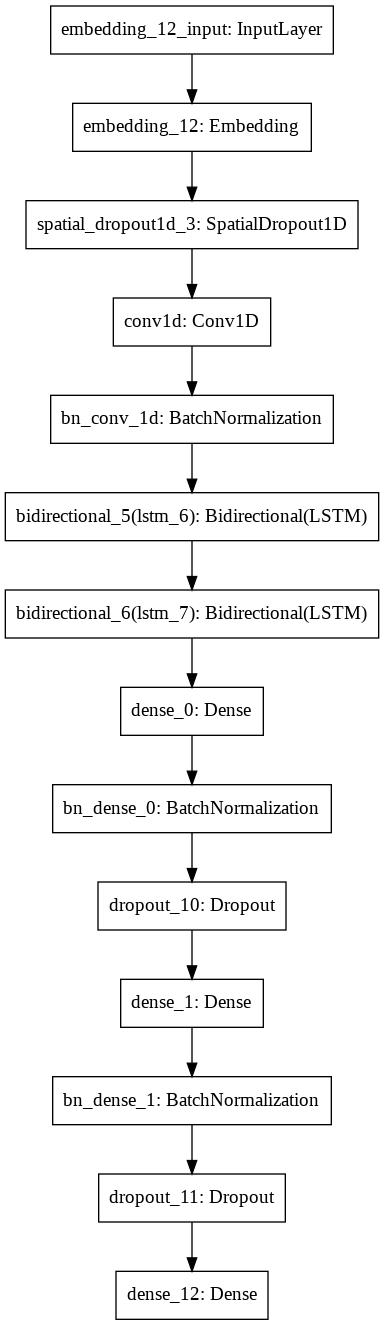

In [ ]:
tf.keras.utils.plot_model(model_08)

In [156]:
print("Starting ....\n")

start_time = time.time()
print(date_time(1))

print("\n \nCompiling the Model....\n")
LEARNING_RATE = 1e-2
OPTIMIZER = Adam(LEARNING_RATE)
EPOCHS = 50
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2

model_08.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer=OPTIMIZER, metrics=["accuracy"])
print("Model Compiled....\n")

Starting ....

Timestamp: 2021-01-28 14:02:11

 
Compiling the Model....

Model Compiled....



In [ ]:

print("Training Model.......\n")

history_08 = model_08.fit(train_padded_seq, 
                          train_labels, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS,
                          callbacks=CALLBACKS,
                          validation_split=VALIDATION_SPLIT,
                          #class_weight=class_weights,
                          verbose=1)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))

Starting ....

Timestamp: 2020-12-16 22:56:37

 
Compiling the Model....

Model Compiled....

Training Model.......

Epoch 1/50
834/834 [==============================] - 97s 117ms/step - loss: 0.2729 - accuracy: 0.7507 - val_loss: 0.2247 - val_accuracy: 0.8901
Epoch 2/50
834/834 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.8437
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
834/834 [==============================] - 96s 115ms/step - loss: 0.1933 - accuracy: 0.8437 - val_loss: 0.3912 - val_accuracy: 0.9108
Epoch 3/50
834/834 [==============================] - 96s 115ms/step - loss: 0.1548 - accuracy: 0.8780 - val_loss: 0.1747 - val_accuracy: 0.8246
Epoch 4/50
834/834 [==============================] - 95s 114ms/step - loss: 0.1416 - accuracy: 0.8909 - val_loss: 0.1691 - val_accuracy: 0.9059
Epoch 5/50
834/834 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9090
Epoch 00005: ReduceLROnPlateau reducing lea

In [ ]:
model_08.save("/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_08.h5")

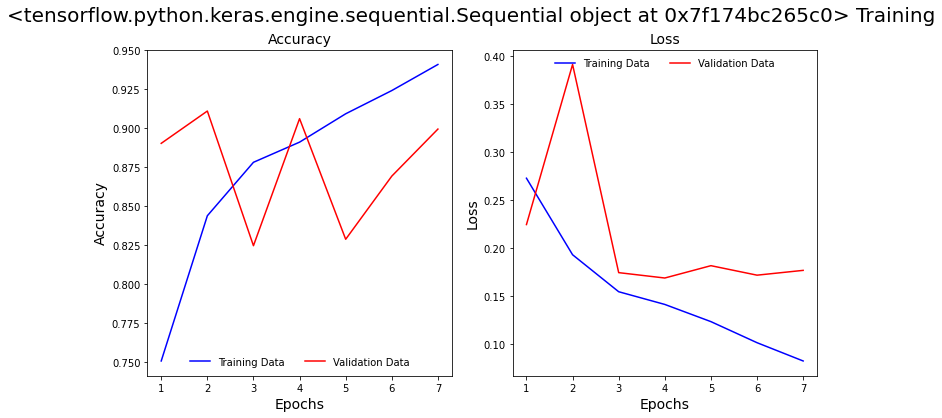

In [ ]:
plot_performance(history_08, model_08)

In [157]:
# Load the model
model_08 = tf.keras.models.load_model('/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_08.h5', compile=False)
# list the loss function
losses = get_weighted_loss(pos_weights, neg_weights)
# compile and train the model
model_08.compile(optimizer='adam', loss=losses, metrics=['accuracy'])

# evaluate model on training dataset
loss_08, acc_08 = model_08.evaluate(train_padded_seq, train_labels, verbose=0)
print('Train Accuracy: %f' % (acc_08*100))
# evaluate model on test dataset dataset
val_loss_08, val_acc_08 = model_08.evaluate(valid_padded_seq, valid_labels, verbose=0)
print('Test Accuracy: %f' % (val_acc_08*100))


print(f"-"*55)
print(f"-----------------Model-08 Evaluation-------------------")
print(f"-"*55)
print(f"|            |     Training        |      Test         |")
print(f"|            |       Data          |      Data         |")
print(f"-"*55)
print(f"| Accuracy   |       {round(acc_08, 3)}          |      {round(loss_08, 3)}        |")
print(f"-"*55)
print(f"| Loss       |       {round(val_acc_08, 3)}         |      {round(val_loss_08, 3)}         |")
print(f"-"*55)

Train Accuracy: 93.129790
Test Accuracy: 90.602696
-------------------------------------------------------
-----------------Model-08 Evaluation-------------------
-------------------------------------------------------
|            |     Training        |      Test         |
|            |       Data          |      Data         |
-------------------------------------------------------
| Accuracy   |       0.931          |      0.127        |
-------------------------------------------------------
| Loss       |       0.906         |      0.165         |
-------------------------------------------------------


In [158]:
model_path='/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_08.h5'

In [159]:
pred_proba, predicted_sentiment = test_sentiment(test_text=test_text, trained_tokenizer = tokenizer, model=model_path, max_length=184)
print(pred_proba)
print(predicted_sentiment)

[[0.32528445 0.6747155 ]]
Positive


## Model-09 CNN_BiDirectional_LSTM_model_03

In [160]:
def create_cnn_bidirectional_LSTM_model_03(num_class):
    model = Sequential()
    model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    model.add(tf.keras.layers.Conv1D(256, kernel_size=8, strides=2, padding="valid",
                     activation='relu', name='conv1d'))
    model.add(tf.keras.layers.BatchNormalization(name='bn_conv_1d'))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.3,)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)))
    
    for idx, units in enumerate([128, 64]):
        model.add(tf.keras.layers.Dense(units, activation = 'relu', name=f'dense_{idx}'))
        model.add(tf.keras.layers.BatchNormalization(name=f'bn_dense_{idx}'))
        model.add(tf.keras.layers.Dropout(0.5))
    
    if num_class>=2:
        model.add(tf.keras.layers.Dense(num_class, activation ='softmax'))
    else:
        model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
    
    model.summary()
    return model 

In [161]:
model_09 = create_cnn_bidirectional_LSTM_model_03(num_class=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 184, 128)          7840768   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 184, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 89, 256)           262400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, 89, 256)           1024      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 89, 512)           1050624   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense_0 (Dense)              (None, 128)              

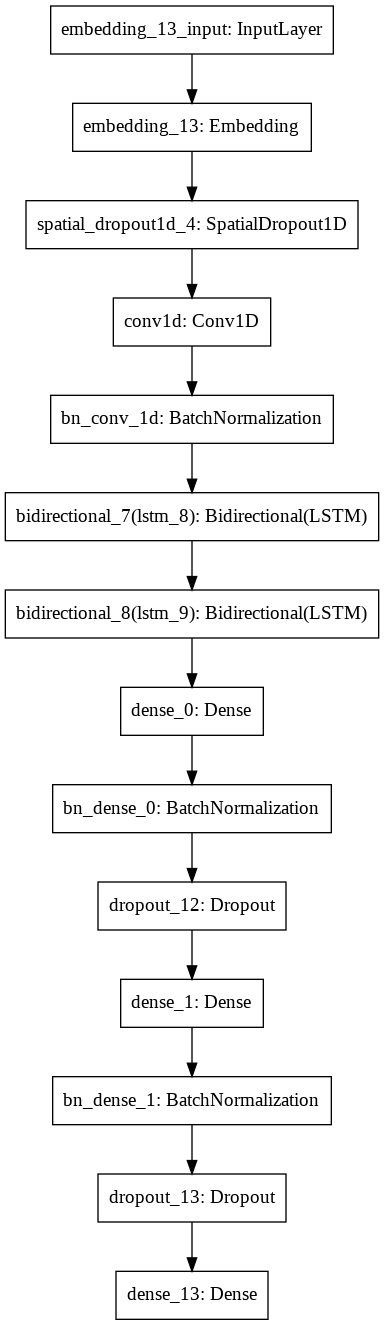

In [ ]:
tf.keras.utils.plot_model(model_09)

In [162]:
print("Starting ....\n")

start_time = time.time()
print(date_time(1))

print("\n \nCompiling the Model....\n")
LEARNING_RATE = 1e-2
OPTIMIZER = Adam(LEARNING_RATE)
EPOCHS = 50
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2

model_09.compile(loss=get_weighted_loss(pos_weights, neg_weights), optimizer=OPTIMIZER, metrics=["accuracy"])
print("Model Compiled....\n")

Starting ....

Timestamp: 2021-01-28 14:04:17

 
Compiling the Model....

Model Compiled....



In [ ]:

print("Training Model.......\n")

history_09 = model_09.fit(train_padded_seq, 
                          train_labels, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS,
                          callbacks=CALLBACKS,
                          validation_split=VALIDATION_SPLIT,
                          #class_weight=class_weights,
                          verbose=1)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))

Starting ....

Timestamp: 2020-12-16 23:15:55

 
Compiling the Model....

Model Compiled....

Training Model.......

Epoch 1/50
834/834 [==============================] - 763s 914ms/step - loss: 0.2594 - accuracy: 0.7643 - val_loss: 0.2108 - val_accuracy: 0.8989
Epoch 2/50
834/834 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.8695
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
834/834 [==============================] - 753s 902ms/step - loss: 0.1694 - accuracy: 0.8695 - val_loss: 0.2507 - val_accuracy: 0.7261
Epoch 3/50
834/834 [==============================] - 760s 911ms/step - loss: 0.1314 - accuracy: 0.9031 - val_loss: 0.1581 - val_accuracy: 0.8913
Epoch 4/50
834/834 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9133
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
834/834 [==============================] - 756s 907ms/step - loss: 0.1170 - accuracy: 0.9133 - val_loss: 

In [ ]:
model_09.save("/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_09.h5")

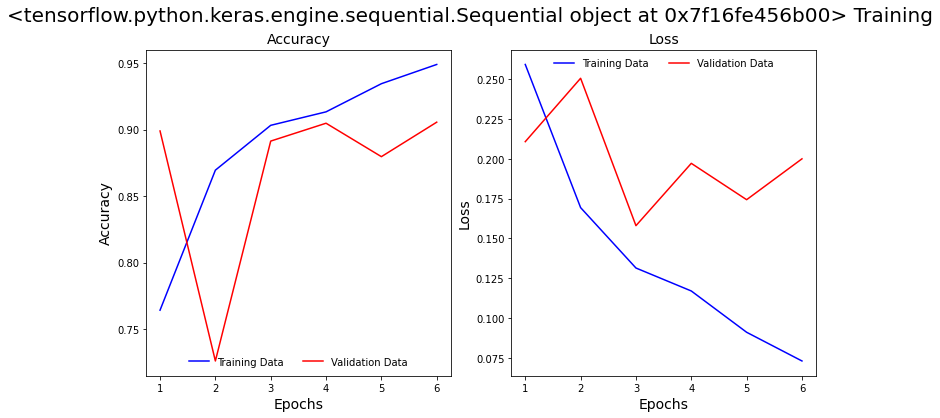

In [ ]:
plot_performance(history_09, model_09)

In [163]:
# Load the model
model_09 = tf.keras.models.load_model('/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_09.h5', compile=False)
# list the loss function
losses = get_weighted_loss(pos_weights, neg_weights)
# compile and train the model
model_09.compile(optimizer='adam', loss=losses, metrics=['accuracy'])

# evaluate model on training dataset
loss_09, acc_09 = model_09.evaluate(train_padded_seq, train_labels, verbose=0)
print('Train Accuracy: %f' % (acc*100))
# evaluate model on test dataset dataset
val_loss_09, val_acc_09 = model_09.evaluate(valid_padded_seq, valid_labels, verbose=0)
print('Test Accuracy: %f' % (val_acc*100))

print(f"-"*55)
print(f"-----------------Model-05 Evaluation-------------------")
print(f"-"*55)
print(f"|            |     Training        |      Test         |")
print(f"|            |       Data          |      Data         |")
print(f"-"*55)
print(f"| Accuracy   |       {round(acc_09, 3)}          |      {round(loss_09, 3)}        |")
print(f"-"*55)
print(f"| Loss       |       {round(val_acc_09, 3)}         |      {round(val_loss_09, 3)}         |")
print(f"-"*55)

Train Accuracy: 91.958892
Test Accuracy: 89.079458
-------------------------------------------------------
-----------------Model-05 Evaluation-------------------
-------------------------------------------------------
|            |     Training        |      Test         |
|            |       Data          |      Data         |
-------------------------------------------------------
| Accuracy   |       0.923          |      0.118        |
-------------------------------------------------------
| Loss       |       0.899         |      0.153         |
-------------------------------------------------------


In [164]:
model_path='/content/drive/MyDrive/sentiment_analysis/output/models/saved_models/model_09.h5'

In [165]:
pred_proba, predicted_sentiment = test_sentiment(test_text=test_text, trained_tokenizer = tokenizer, model=model_path, max_length=184)
print(pred_proba)
print(predicted_sentiment)

[[0.2948922 0.7051078]]
Positive


## Model Evaluation

In [ ]:
txt = ["four month old loves blankies ! loves chew put face . took one star wash washer bib . velcro messes ! hassle took star otherwise love !"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=MAX_LEN)

# Predictions
pred_01 = model_01.predict(padded)
pred_02 = model_02.predict(padded)
pred_05 = model_05.predict(padded)
pred_06 = model_06.predict(padded)
pred_07 = model_07.predict(padded)
pred_08 = model_08.predict(padded)
pred_09 = model_09.predict(padded)

labels = ['negative', 'positive']
print("Model_01:\n  Prediction_Probabilities: {}\n  Predicted_Class: {}\n".format(pred_01, labels[np.argmax(pred_01)]))
print("Model_02:\n  Prediction_Probabilities: {}\n  Predicted_Class: {}\n".format(pred_02, labels[np.argmax(pred_02)]))
print("Model_05:\n  Prediction_Probabilities: {}\n  Predicted_Class: {}\n".format(pred_05, labels[np.argmax(pred_05)]))
print("Model_06:\n  Prediction_Probabilities: {}\n  Predicted_Class: {}\n".format(pred_06, labels[np.argmax(pred_06)]))
print("Model_07:\n  Prediction_Probabilities: {}\n  Predicted_Class: {}\n".format(pred_07, labels[np.argmax(pred_07)]))
print("Model_08:\n  Prediction_Probabilities: {}\n  Predicted_Class: {}\n".format(pred_06, labels[np.argmax(pred_08)]))
print("Model_09:\n  Prediction_Probabilities: {}\n  Predicted_Class: {}\n".format(pred_07, labels[np.argmax(pred_09)]))


Model_01:
  Prediction_Probabilities: [[0.6198986  0.38010135]]
  Predicted_Class: negative

Model_02:
  Prediction_Probabilities: [[0.00661786 0.9933822 ]]
  Predicted_Class: positive

Model_05:
  Prediction_Probabilities: [[0.06575476 0.9342453 ]]
  Predicted_Class: positive

Model_06:
  Prediction_Probabilities: [[0.19969574 0.80030423]]
  Predicted_Class: positive

Model_07:
  Prediction_Probabilities: [[0.5016094  0.49839064]]
  Predicted_Class: negative

Model_08:
  Prediction_Probabilities: [[0.19969574 0.80030423]]
  Predicted_Class: positive

Model_09:
  Prediction_Probabilities: [[0.5016094  0.49839064]]
  Predicted_Class: positive

